In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [3]:
# For Jupyter notebook
%matplotlib inline

### PART 1: DATA PREPARATION  

In [33]:
# Load the data
data = pd.read_csv('wage_eq_czech_data.csv')

In [34]:
# Rename columns for easier handling
data.columns = [
    'period', 
    'inflation', 
    'nominal_wage', 
    'inflation_exp_1y', 
    'inflation_exp_3y', 
    'job_vacancies',
    'unemployed',
    'labor_productivity'
]
# Clean the period column and convert to datetime
data['period'] = pd.to_datetime(data['period'])

# Sort by date
data = data.sort_values('period')

/var/folders/tz/y0sqk00n3_bd7tlckl9zbspw0000gn/T/ipykernel_1122/662557420.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['period'] = pd.to_datetime(data['period'])


In [35]:
# Drop rows with missing values in key original columns
data = data.dropna(subset=['period', 'nominal_wage', 'inflation', 'inflation_exp_1y', 'inflation_exp_3y'])
print(f"Observations after dropping missing values in original columns: {len(data)}")

Observations after dropping missing values in original columns: 71


In [36]:
# Create log variables for calculations
data['log_wage'] = np.log(data['nominal_wage'])

# Calculate vacancy-to-unemployment ratio
data['vu_ratio'] = data['job_vacancies'] / data['unemployed']

# Add dummy variables
data['Q1_2021_dummy'] = ((data['period'] >= '2021-01-01') & (data['period'] <= '2021-03-31')).astype(int)
data['Q1_2022_dummy'] = ((data['period'] >= '2022-01-01') & (data['period'] <= '2022-03-31')).astype(int)

In [40]:
# Create lags 

# For wage growth: first create the variable, then its lags
data['wage_growth'] = data['log_wage'].diff() * 100  # quarterly wage growth in percentages
data['wage_growth_lag1'] = data['wage_growth'].shift(1)
data['wage_growth_lag2'] = data['wage_growth'].shift(2)
data['wage_growth_lag3'] = data['wage_growth'].shift(3)
data['wage_growth_lag4'] = data['wage_growth'].shift(4)

# For inflation expectations
data['inflation_exp_1y_lag1'] = data['inflation_exp_1y'].shift(1)
data['inflation_exp_1y_lag2'] = data['inflation_exp_1y'].shift(2)
data['inflation_exp_1y_lag3'] = data['inflation_exp_1y'].shift(3)
data['inflation_exp_1y_lag4'] = data['inflation_exp_1y'].shift(4)

# For inflation
data['inflation_lag1'] = data['inflation'].shift(1)

# For catch-up term: first create the variable, then its lags
data['catch_up'] = data['inflation_lag1'] - data['inflation_exp_1y_lag1']
data['catch_up_lag1'] = data['catch_up'].shift(1)
data['catch_up_lag2'] = data['catch_up'].shift(2)
data['catch_up_lag3'] = data['catch_up'].shift(3)

# For labor market tightness
data['vu_ratio_lag1'] = data['vu_ratio'].shift(1)
data['vu_ratio_lag2'] = data['vu_ratio'].shift(2)
data['vu_ratio_lag3'] = data['vu_ratio'].shift(3)
data['vu_ratio_lag4'] = data['vu_ratio'].shift(4)

# For productivity
data['labor_productivity_lag1'] = data['labor_productivity'].shift(1)

# Expected inflation change
data['expected_inflation_change'] = data['inflation_exp_1y'] - data['inflation_lag1']

In [41]:
# Create clean dataset for analysis
variables_needed = [
    'period', 'wage_growth', 'inflation', 'inflation_exp_1y', 'inflation_exp_3y',
    'vu_ratio', 'labor_productivity', 'catch_up', 'Q1_2021_dummy', 'Q1_2022_dummy',
    'wage_growth_lag1', 'wage_growth_lag2', 'wage_growth_lag3', 'wage_growth_lag4',
    'inflation_exp_1y_lag1', 'inflation_exp_1y_lag2', 'inflation_exp_1y_lag3', 'inflation_exp_1y_lag4',
    'catch_up_lag1', 'catch_up_lag2', 'catch_up_lag3',
    'vu_ratio_lag1', 'vu_ratio_lag2', 'vu_ratio_lag3', 'vu_ratio_lag4',
    'labor_productivity_lag1'
]

# Drop rows with missing values in any required variable
data_clean = data.dropna(subset=variables_needed)
print(f"\nFinal dataset size: {len(data_clean)} observations")
print(f"Date range of clean data: {data_clean['period'].min()} to {data_clean['period'].max()}")


Final dataset size: 66 observations
Date range of clean data: 2008-06-30 00:00:00 to 2024-09-30 00:00:00


### PART 2: EXPLORATORY ANALYSIS 

In [42]:
data_clean.head(3)

,period,inflation,nominal_wage,inflation_exp_1y,inflation_exp_3y,job_vacancies,unemployed,labor_productivity,log_wage,vu_ratio,...,catch_up,catch_up_lag1,catch_up_lag2,catch_up_lag3,vu_ratio_lag1,vu_ratio_lag2,vu_ratio_lag3,vu_ratio_lag4,labor_productivity_lag1,expected_inflation_change
65,2008-06-30,6.7,22246,4.9,4.0,151.88,297.88,1.74,10.009917,0.509870,...,2.2,0.5,-0.8,-0.5,0.449896,0.397515,0.376541,0.332452,1.67,-2.2
64,2008-09-30,6.6,22181,4.1,3.8,139.56,314.56,0.62,10.006991,0.443667,...,1.8,2.2,0.5,-0.8,0.509870,0.449896,0.397515,0.376541,1.74,-2.6
63,2008-12-31,3.6,24309,2.9,3.0,91.19,352.25,-2.79,10.098602,0.258879,...,2.5,1.8,2.2,0.5,0.443667,0.509870,0.449896,0.397515,0.62,-3.7


In [43]:
# Display basic statistics
print("\nDescriptive Statistics:")
descriptive_stats = data_clean[['wage_growth', 'inflation', 'inflation_exp_1y', 'inflation_exp_3y', 
                              'vu_ratio', 'catch_up', 'labor_productivity']].describe()
print(descriptive_stats)


Descriptive Statistics:
       wage_growth  inflation  inflation_exp_1y  inflation_exp_3y   vu_ratio  \
count    66.000000  66.000000         66.000000         66.000000  66.000000   
mean      1.123640   3.444091          3.028788          3.212121   0.630767   
std       5.771395   4.052008          2.151905          1.254593   0.563488   
min     -12.044320   0.000000          1.300000          2.100000   0.054848   
25%      -2.071516   1.250000          1.900000          2.500000   0.083002   
50%       1.660197   2.300000          2.200000          2.700000   0.398267   
75%       6.485648   3.375000          2.750000          3.450000   1.133607   
max      10.169161  18.000000         10.300000          7.500000   1.750000   

        catch_up  labor_productivity  
count  66.000000           66.000000  
mean    0.459242            1.121364  
std     2.081430            2.643945  
min    -2.000000           -7.930000  
25%    -0.800000           -0.440000  
50%     0.000000    

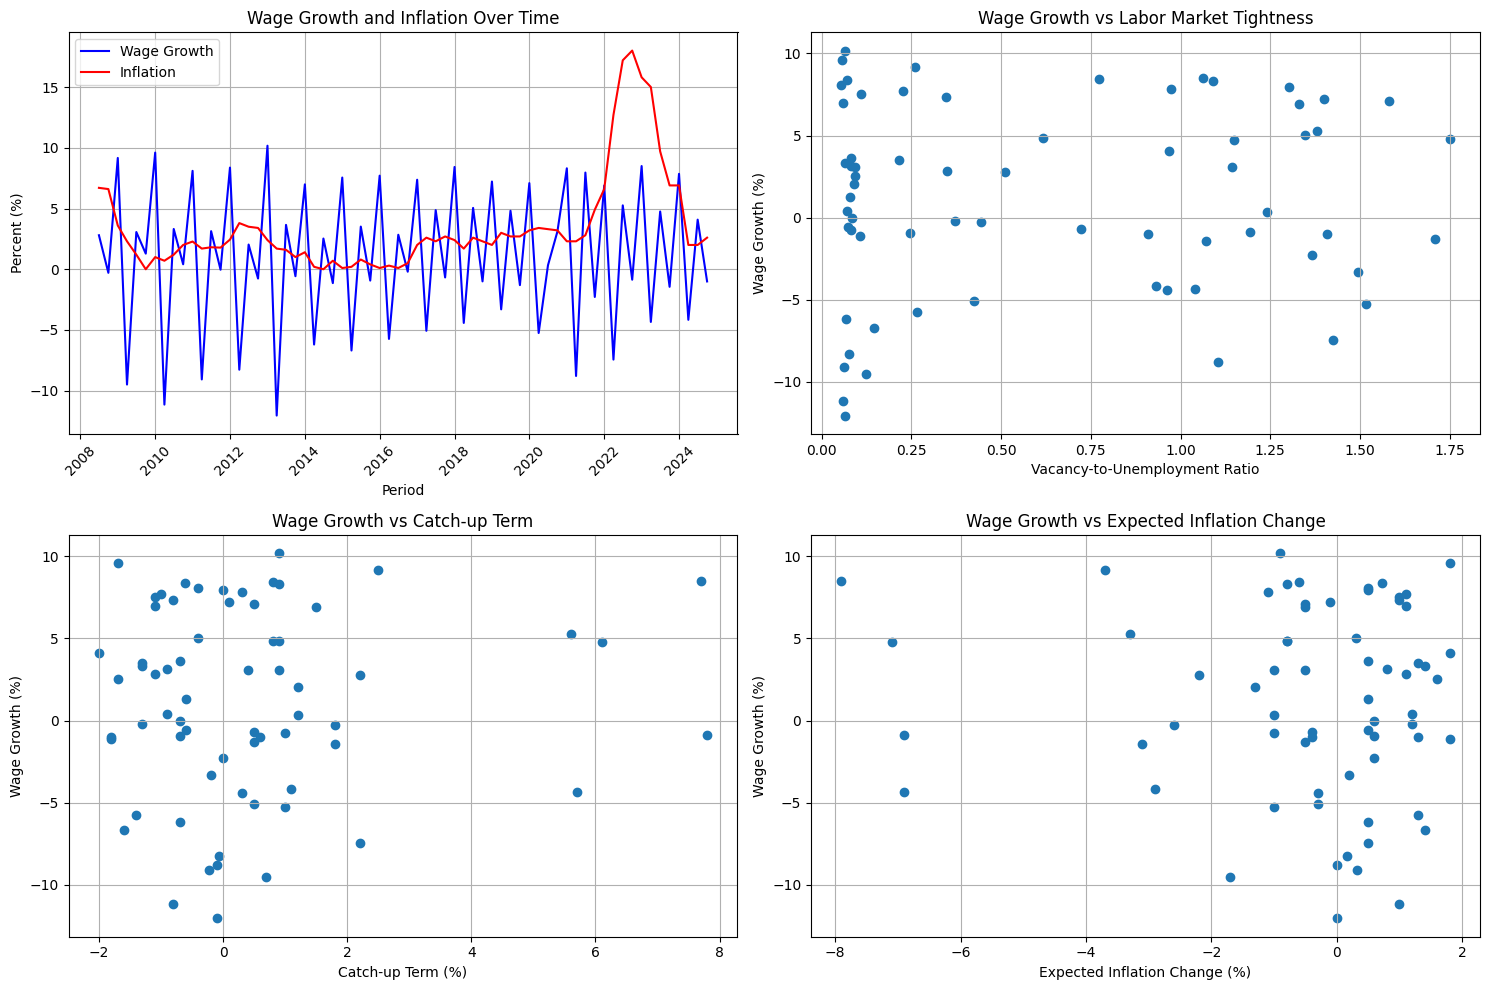

In [44]:
plt.figure(figsize=(15, 10))

# Plot 1: Time series of key variables
plt.subplot(2, 2, 1)
plt.plot(data_clean['period'], data_clean['wage_growth'], 'b-', label='Wage Growth')
plt.plot(data_clean['period'], data_clean['inflation'], 'r-', label='Inflation')
plt.title('Wage Growth and Inflation Over Time')
plt.xlabel('Period')
plt.ylabel('Percent (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Plot 2: Wage Growth vs v/u Ratio
plt.subplot(2, 2, 2)
plt.scatter(data_clean['vu_ratio'], data_clean['wage_growth'])
plt.title('Wage Growth vs Labor Market Tightness')
plt.xlabel('Vacancy-to-Unemployment Ratio')
plt.ylabel('Wage Growth (%)')
plt.grid(True)

# Plot 3: Wage Growth vs Catch-up Term
plt.subplot(2, 2, 3)
plt.scatter(data_clean['catch_up'], data_clean['wage_growth'])
plt.title('Wage Growth vs Catch-up Term')
plt.xlabel('Catch-up Term (%)')
plt.ylabel('Wage Growth (%)')
plt.grid(True)

# Plot 4: Wage Growth vs Expected Inflation Change
plt.subplot(2, 2, 4)
plt.scatter(data_clean['expected_inflation_change'], data_clean['wage_growth'])
plt.title('Wage Growth vs Expected Inflation Change')
plt.xlabel('Expected Inflation Change (%)')
plt.ylabel('Wage Growth (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

### PART 3: MODEL ESTIMATION

$r"w - w_{-1} = (p^e - p_{-1}) + \alpha(p_{-1} - p^e_{-1}) + \beta(x - \alpha x_{-1}) + z_w"$

In [45]:
if len(data_clean) > 0:
    print("\nEstimating wage equation following Bernanke-Blanchard methodology...")

    # FULL WAGE EQUATION as in Bernanke-Blanchard paper
    print("\nWAGE EQUATION ESTIMATION (Full Model)")
    
    # First, verify that all required columns exist in data_clean
    model_vars = [
        'wage_growth_lag1', 'wage_growth_lag2', 'wage_growth_lag3', 'wage_growth_lag4',
        'inflation_exp_1y_lag1', 'inflation_exp_1y_lag2', 'inflation_exp_1y_lag3', 'inflation_exp_1y_lag4',
        'catch_up', 'catch_up_lag1', 'catch_up_lag2', 'catch_up_lag3',
        'vu_ratio_lag1', 'vu_ratio_lag2', 'vu_ratio_lag3', 'vu_ratio_lag4',
        'labor_productivity_lag1',
        'Q1_2021_dummy', 'Q1_2022_dummy'
    ]
    
    print("Checking model variables:", all(var in data_clean.columns for var in model_vars))
    
    # Create design matrix X
    X_wage = add_constant(data_clean[model_vars])
    y_wage = data_clean['wage_growth']

    # Check if we have enough observations for estimation
    if len(data_clean) <= X_wage.shape[1]:
        print(f"Warning: Not enough observations ({len(data_clean)}) for the model with {X_wage.shape[1]} parameters.")
        print("Consider using a more parsimonious model or collecting more data.")
    else:
        model_wage = OLS(y_wage, X_wage).fit()
        print(model_wage.summary().tables[1])


Estimating wage equation following Bernanke-Blanchard methodology...

WAGE EQUATION ESTIMATION (Full Model)
Checking model variables: True
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.8784      0.960      1.957      0.056      -0.054       3.811
wage_growth_lag1           -0.6693      0.170     -3.946      0.000      -1.011      -0.328
wage_growth_lag2           -0.5992      0.177     -3.383      0.001      -0.956      -0.243
wage_growth_lag3           -0.5966      0.177     -3.370      0.002      -0.953      -0.240
wage_growth_lag4            0.2725      0.167      1.628      0.110      -0.064       0.609
inflation_exp_1y_lag1      -1.1893      0.774     -1.536      0.131      -2.748       0.369
inflation_exp_1y_lag2       1.9994      1.245      1.606      0.115      -0.506       4.505
inflation_exp_1y_lag3      -0.95

### PART 4: RESULTS ANALYSIS

In [47]:
# Extract and summarize coefficients
print("\nSum of Coefficients by Variable Group:")
coef_dict = {
    'Lagged wage growth (sum)': model_wage.params.filter(like='wage_growth').sum(),
    'Short-run inflation expectations (sum)': model_wage.params.filter(like='inflation_exp_1y').sum(),
    'Catch-up term (sum)': model_wage.params.filter(like='catch_up').sum(),
    'Labor market tightness (v/u) (sum)': model_wage.params.filter(like='vu_ratio').sum(),
    'Productivity': model_wage.params['labor_productivity_lag1'],
    'Q1 2021 dummy': model_wage.params['Q1_2021_dummy'],
    'Q1 2022 dummy': model_wage.params['Q1_2022_dummy']
}

for var, coef in coef_dict.items():
    print(f"{var}: {coef:.4f}")

# Compare with original Bernanke-Blanchard findings
print("\nComparison with Bernanke-Blanchard US findings:")
print(f"Czech catch-up coefficient (sum): {coef_dict['Catch-up term (sum)']:.4f}")
print(f"US catch-up coefficient (sum): -0.024")
print(f"Czech v/u coefficient (sum): {coef_dict['Labor market tightness (v/u) (sum)']:.4f}")
print(f"US v/u coefficient (sum): 0.693")

# Print the estimated wage equation
print("\nEstimated Wage Equation for Czech Republic (summarized with coefficient sums):")
equation = f"w - w(-1) = {model_wage.params['const']:.4f}"
equation += f" + {coef_dict['Lagged wage growth (sum)']:.4f}(lagged wage growth)"
equation += f" + {coef_dict['Short-run inflation expectations (sum)']:.4f}(inflation expectations)"
equation += f" + {coef_dict['Catch-up term (sum)']:.4f}(catch-up)"
equation += f" + {coef_dict['Labor market tightness (v/u) (sum)']:.4f}(v/u ratio)"
equation += f" + {coef_dict['Productivity']:.4f}(productivity)"
equation += f" + {coef_dict['Q1 2021 dummy']:.4f}(Q1 2021 dummy)"
equation += f" + {coef_dict['Q1 2022 dummy']:.4f}(Q1 2022 dummy)"

print(equation)


Sum of Coefficients by Variable Group:
Lagged wage growth (sum): -1.5926
Short-run inflation expectations (sum): -0.0321
Catch-up term (sum): 0.0956
Labor market tightness (v/u) (sum): 1.7688
Productivity: -0.0226
Q1 2021 dummy: -3.2064
Q1 2022 dummy: 0.1783

Comparison with Bernanke-Blanchard US findings:
Czech catch-up coefficient (sum): 0.0956
US catch-up coefficient (sum): -0.024
Czech v/u coefficient (sum): 1.7688
US v/u coefficient (sum): 0.693

Estimated Wage Equation for Czech Republic (summarized with coefficient sums):
w - w(-1) = 1.8784 + -1.5926(lagged wage growth) + -0.0321(inflation expectations) + 0.0956(catch-up) + 1.7688(v/u ratio) + -0.0226(productivity) + -3.2064(Q1 2021 dummy) + 0.1783(Q1 2022 dummy)


### PART 5: VISUALIZATION

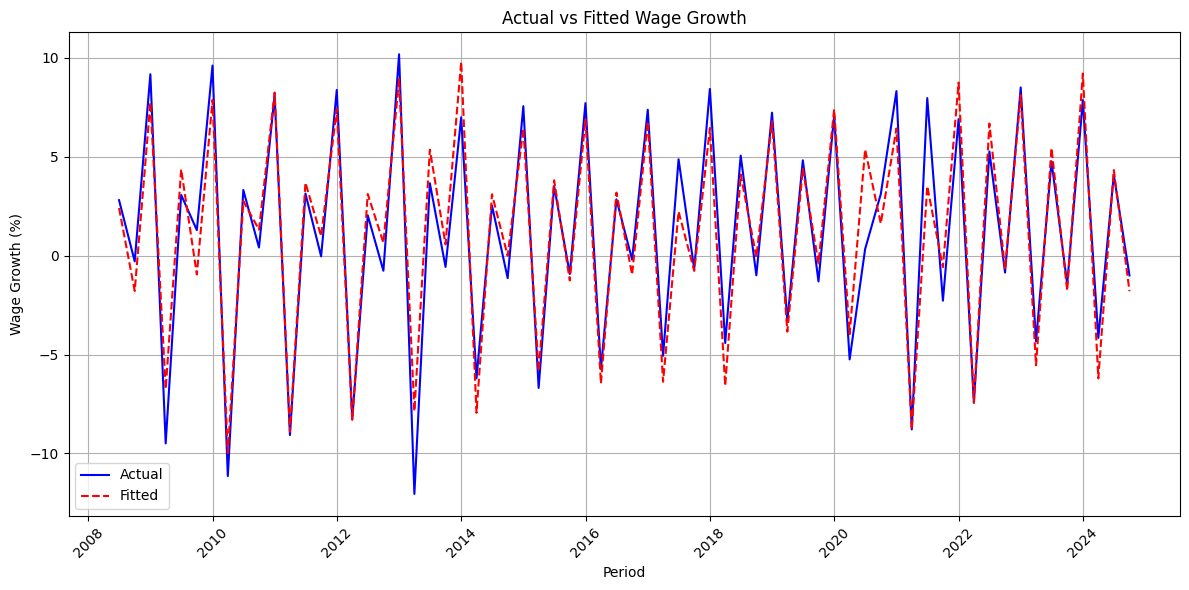

In [48]:
# Plot actual vs. fitted wage growth
plt.figure(figsize=(12, 6))
plt.plot(data_clean['period'], data_clean['wage_growth'], 'b-', label='Actual')
plt.plot(data_clean['period'], model_wage.fittedvalues, 'r--', label='Fitted')
plt.title('Actual vs Fitted Wage Growth')
plt.xlabel('Period')
plt.ylabel('Wage Growth (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()